In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q umap-learn tensorflow-addons
import umap
import numpy as np
import tensorflow_addons as tfa

import random
import tensorflow as tf
from tqdm.notebook import tqdm

from tensorflow.keras.datasets import mnist
 
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG
from matplotlib import pyplot as plt
import math
import plotly.express as px

np.random.seed(37)

     |████████████████████████████████| 81kB 4.9MB/s 
     |████████████████████████████████| 686kB 52.1MB/s 
     |████████████████████████████████| 1.2MB 57.3MB/s 


In [19]:
num_classes = 10
epochs = 100
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
model_basepath="/content/drive/MyDrive/mlexperiments/siamese/"

In [20]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels).astype(np.float32)

def get_rand(d,num_classes):
  inc = random.randrange(1, num_classes)
  return (d + inc) % num_classes 

def create_triplets(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    ''' 
    labels = []
    triplets = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]  
            z3 = digit_indices[get_rand(d,num_classes)][i]

            # print("triplet:", class_names[d]+ str(i), class_names[d]+ str(i+1), class_names[get_rand(d,num_classes)]+ str(i), )
            triplets += [[x[z1], x[z2], x[z3]]]
            # print(z1,z2,z3)

            z3 = digit_indices[get_rand(d,num_classes)][i]
            triplets += [[x[z2],x[z1], x[z3]]]
            # print(z2,z1,z3)
            labels += [1, 0]
    return np.array(triplets)



In [21]:

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) =   cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)] # indices of each class in array
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)


## visualize pairs


In [22]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)



def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def create_base_conv_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
  
    input = Input(shape=input_shape) 
    x = Conv2D(filters=32, kernel_size=3, padding='same', name="conv1" )(input)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3,  name="conv2", padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3, name="conv3", padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3,  name="conv4" , padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x) 
    x = Dropout(0.1)(x)
    x = Conv2D(filters=64, kernel_size=3,  name="conv5", padding='same')(x)
    x = Flatten()(x)
    x = Dense(256, activation=None)(x)
    x = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1) , name="dense128")(x)
    
    return Model(input, x)

def get_model_sequential(input_shape):
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(pool_size=2), 
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2), 
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=None), # No activation on final dense layer
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

  ])

  return model

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


def plot_history(history, title=""):

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
   
  # Plot training & validation accuracy values
  axes[0].plot(history.history['accuracy'])
  axes[0].plot(history.history['val_accuracy'])
  axes[0].title.set_text('Model accuracy |  ' + title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  # plt.show()

  # Plot training & validation loss values
  axes[1].plot(history.history['loss'])
  axes[1].plot(history.history['val_loss'])
  axes[1].title.set_text('Model Losss | ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  fig.tight_layout()
  plt.show()

def plot_features(model, title="UMAP Embedding Projection", metric="euclidean"):
  test_features = model(x_test)
  print("Compute UMAP for vector with shape", test_features.shape, " metric:", metric)
  reducer = umap.UMAP(n_neighbors=15, n_components=2, metric=metric)
  embedding = reducer.fit_transform(test_features)

  colors = [ x[0] for x in y_test] 
  acm = [class_names[x] for x in colors]

  fig = px.scatter(
      x=embedding[:, 0],
      y=embedding[:, 1],
      color=acm,
      opacity=0.5,
      hover_name=acm,
      # symbol=acm,
      width=1200,
      height=900,
      title=title,
  )
  fig.show()  

## Classification Model Setup


In [23]:
def get_classification_model():
  classsification_base_network = create_base_conv_network(input_shape) 
  x = classsification_base_network.get_layer("dense128").output
  x = Dense(10, activation='relu', name="dense10")(x)
  classification_model = Model(
      inputs=classsification_base_network.input, outputs=x, name="classification_model"
  )

  classification_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return classification_model
  # SVG(model_to_dot(classification_model, show_layer_names=True, show_shapes=True, dpi=60).create(prog='dot', format='svg'))
  # classification_model.summary()

## Metric Learning Model Setup

In [24]:
# network definition

def get_siamese_contrastive(l2_normalize=False):
  siamese_base_network = create_base_conv_network(input_shape)
  x = siamese_base_network.get_layer("dense128").output
  if l2_normalize:
    x = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1), name="normalize1")(x)
    # x = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1), name="normalize2")(x) 
  siamese_base_network = Model(
      inputs=siamese_base_network.input, outputs=x, name="classification_model"
  ) 

  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  processed_a = siamese_base_network(input_a)
  processed_b = siamese_base_network(input_b)

  distance = Lambda(euclidean_distance,
                    output_shape=eucl_dist_output_shape)([processed_a, processed_b])

  siamese_model = Model([input_a, input_b], distance)
  # train
  siamese_model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(0.001), metrics=[accuracy])
  return siamese_model
# siamese_base_network.summary()
# SVG(model_to_dot(base_network, show_layer_names=True, show_shapes=True, dpi=50).create(prog='dot', format='svg'))
# SVG(model_to_dot(siamese_model, show_layer_names=True, show_shapes=True, dpi=50).create(prog='dot', format='svg'))

def get_siamese_triplet():
  triplet_model = get_model_sequential(input_shape)
  triplet_model.compile( optimizer=tf.keras.optimizers.Adam(0.001),  loss=tfa.losses.TripletSemiHardLoss(), metrics=[accuracy] )
  return triplet_model


In [25]:
def save_model(name, model):
  print(">>> Saving model", name) 
  model.save("models/" + name)  
  !cp -r models $model_basepath 
 

In [26]:
trained_models=[]
def train_models(model_details):
  # train classificatification model 
  
  for model_detail in model_details:
    
    x_train, y_train, x_test, y_test =  model_detail["x_train"],  model_detail["y_train"],  model_detail["x_test"], model_detail["y_test"]
    name, model =  model_detail["name"],  model_detail["model"]
    print("Training model", name) 
    history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)
    plot_history(history, title=name)
    # plot_features(base_network, title="UMAP Embedding Projection CIFAR10 - " + name)

    save_model(name, model) 
    trained_models.append({"name":name, "model":model})

Training model classification
Epoch 1/100
782/782 [==============================] - 4s 5ms/step - loss: 1.8524 - accuracy: 0.3505 - val_loss: 1.2605 - val_accuracy: 0.5707
Epoch 2/100
782/782 [==============================] - 3s 4ms/step - loss: 1.1494 - accuracy: 0.6072 - val_loss: 1.0042 - val_accuracy: 0.6620
Epoch 3/100
782/782 [==============================] - 3s 4ms/step - loss: 0.9450 - accuracy: 0.6786 - val_loss: 0.9228 - val_accuracy: 0.6929
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: 0.8370 - accuracy: 0.7164 - val_loss: 0.9090 - val_accuracy: 0.6945
Epoch 5/100
782/782 [==============================] - 3s 4ms/step - loss: 0.7529 - accuracy: 0.7448 - val_loss: 0.8674 - val_accuracy: 0.7086
Epoch 6/100
782/782 [==============================] - 3s 4ms/step - loss: 0.6961 - accuracy: 0.7657 - val_loss: 0.8426 - val_accuracy: 0.7158
Epoch 7/100
782/782 [==============================] - 3s 4ms/step - loss: 0.6331 - accuracy: 0.7862 - val_loss:

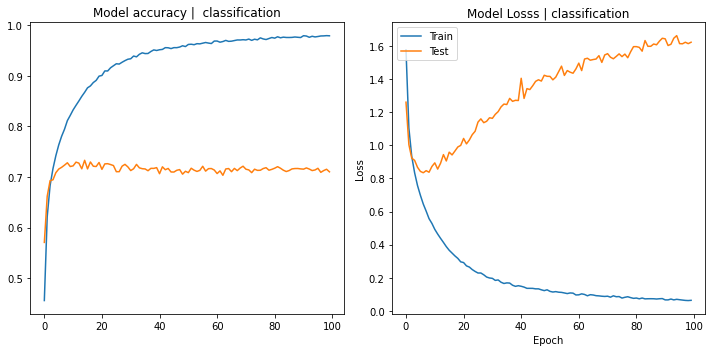

>>> Saving model classification
INFO:tensorflow:Assets written to: models/classification/assets
Training model siamese_contrastive
Epoch 1/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2344 - accuracy: 0.5996 - val_loss: 0.2077 - val_accuracy: 0.6831
Epoch 2/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1946 - accuracy: 0.7003 - val_loss: 0.1844 - val_accuracy: 0.7231
Epoch 3/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1784 - accuracy: 0.7348 - val_loss: 0.1709 - val_accuracy: 0.7466
Epoch 4/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1647 - accuracy: 0.7608 - val_loss: 0.1694 - val_accuracy: 0.7489
Epoch 5/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1559 - accuracy: 0.7783 - val_loss: 0.1657 - val_accuracy: 0.7594
Epoch 6/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1484 - accuracy: 0.7931 - val_loss: 0.1629 - val_accuracy: 

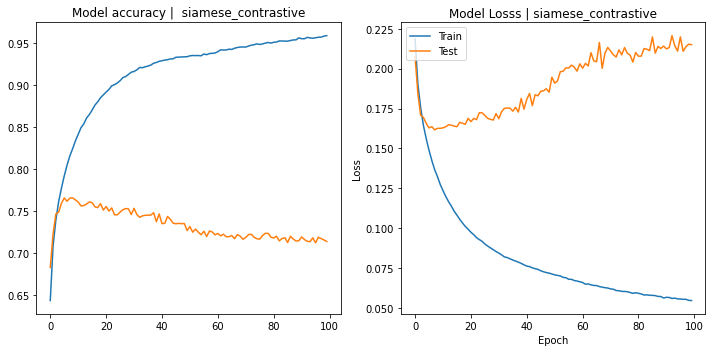

>>> Saving model siamese_contrastive
INFO:tensorflow:Assets written to: models/siamese_contrastive/assets
Training model siamese_triplet
Epoch 1/100
782/782 [==============================] - 6s 5ms/step - loss: 0.9690 - accuracy: 0.0982 - val_loss: 0.9469 - val_accuracy: 0.0998
Epoch 2/100
782/782 [==============================] - 4s 5ms/step - loss: 0.9452 - accuracy: 0.1041 - val_loss: 0.9302 - val_accuracy: 0.0998
Epoch 3/100
782/782 [==============================] - 4s 5ms/step - loss: 0.9179 - accuracy: 0.1003 - val_loss: 0.8836 - val_accuracy: 0.0998
Epoch 4/100
782/782 [==============================] - 4s 5ms/step - loss: 0.8840 - accuracy: 0.1021 - val_loss: 0.8826 - val_accuracy: 0.0998
Epoch 5/100
782/782 [==============================] - 4s 5ms/step - loss: 0.8521 - accuracy: 0.0983 - val_loss: 0.8305 - val_accuracy: 0.0998
Epoch 6/100
782/782 [==============================] - 4s 5ms/step - loss: 0.8309 - accuracy: 0.0997 - val_loss: 0.8253 - val_accuracy: 0.0998
Epoch

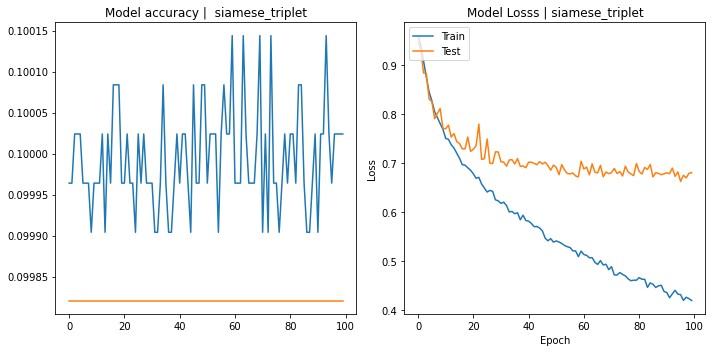

>>> Saving model siamese_triplet
INFO:tensorflow:Assets written to: models/siamese_triplet/assets


In [27]:
siamese_triplet_model = get_siamese_triplet()
model_details = [
                 {"name": "classification", "model": get_classification_model(), "x_train":x_train ,"y_train": y_train,"x_test":x_test ,"y_test": y_test },
                 {"name": "siamese_contrastive", "model": get_siamese_contrastive(), "x_train":[tr_pairs[:, 0], tr_pairs[:, 1]] ,"y_train": tr_y,"x_test":[te_pairs[:, 0], te_pairs[:, 1]] ,"y_test": te_y },
                 {"name": "siamese_triplet", "model": siamese_triplet_model, "x_train":x_train ,"y_train": y_train,"x_test":x_test ,"y_test": y_test },
                
]

train_models(model_details)

Load Model and Evaluate

In [35]:
from tensorflow import keras
from scipy.spatial.distance import cosine, euclidean, cdist
from sklearn.metrics import roc_curve

model_basepath="/content/drive/MyDrive/mlexperiments/siamese/"
# model_basepath = ""
def get_siamese_base(siamese_model):
 
  siamese_base_model = siamese_model.get_layer("classification_model")
   
  siamese_model =Model(
      inputs=siamese_base_model.input, outputs=siamese_base_model.get_layer("dense128").output
  )
  return siamese_model


siamese_model =  keras.models.load_model(model_basepath +'models/siamese_contrastive',  custom_objects={'contrastive_loss': contrastive_loss})
# siamese_l2_model =  keras.models.load_model(model_basepath +'models/siamesel2',  custom_objects={'contrastive_loss': contrastive_loss})

siamese_base_network = get_siamese_base(siamese_model)
# siamesel2_base_network = get_siamese_base(siamese_l2_model)
 
classsification_model = keras.models.load_model(model_basepath +'models/classification')
classsification_base_network =Model(
    inputs=classsification_model.input, outputs=classsification_model.get_layer("dense128").output
)

siamese_triplet_base_network = keras.models.load_model(model_basepath +'models/siamese_triplet')

In [36]:
plot_features(siamese_triplet_base_network, title="UMAP Embedding Projection CIFAR10 - Siamese Triplet" , metric="cosine" )
plot_features(classsification_base_network, title="UMAP Embedding Projection CIFAR10 - Classification ", metric="cosine" )
plot_features(siamese_base_network, title="UMAP Embedding Projection CIFAR10 - Siamese Contrastive" , metric="cosine" )
# plot_features(siamesel2_base_network, title="UMAP Embedding Projection CIFAR10 - Siamese L2 " , metric="cosine")

Compute UMAP for vector with shape (10000, 128)  metric: cosine


Compute UMAP for vector with shape (10000, 256)  metric: cosine


Compute UMAP for vector with shape (10000, 256)  metric: cosine


# TODO 

- Two input siamese model
- Three input siamese model

- For each pair in test pair, get distance metric ...
- Compute threshold, EER and confussion matrix

In [31]:
def find_eer(fprs, tprs, thresholds):
    """
    Given a set of False Positive Rates, True Positive Rates, and corresponding thresholds output by
    sklearn.metrics.roc_curve(), calculate the Equal Error Rate (EER).

    EER (also known as Crossover Error Rate) is the point on the ROC curve where FPR==FNR.

    """
    fnrs = 1 - tprs
    crossover_idx = np.argwhere(np.diff(np.sign(fprs - fnrs))).item()
    crossover_thresh = thresholds[crossover_idx]
    crossover_error = fnrs[crossover_idx]

    return crossover_idx, crossover_thresh, crossover_error

def find_max_accuracy(fprs, tprs, thresholds):

    accs = []

    for fpr, tpr, thresh in list(zip(fprs, tprs, thresholds)):

        accuracy = 0.5 * (tpr + (1 - fpr))  # tnr = (1-fpr)
        accs.append(accuracy)

    max_acc_idx = np.argmax(accs)

    return accs[max_acc_idx]

def plot_threshold_curves(fprs, fnrs, crossover_error, crossover_thresh):
    """
    Plot two curves and visualized the Equal Error Rate.

    EER (also known as Crossover Error Rate) is the point on the ROC curve where FPR==FNR.

    """

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # plot rate vs. distance
    axs[0].plot(thresholds[1:], fprs[1:], label="False Positive Rate (FPR)")
    axs[0].plot(thresholds[1:], fnrs[1:], label="False Negative Rate (FNR)")
    axs[0].plot(crossover_thresh, crossover_error, "o")
    axs[0].set(xlabel="Distance Threshold")
    axs[0].set(ylabel="Rate (%)")
    axs[0].set_title("Failure Rates vs. Distance Threshold")
    axs[0].legend()

    # plot ROC curve
    axs[1].plot(fprs, tprs)
    axs[1].plot((1, 0), (0, 1))
    axs[1].plot(crossover_error, (1 - crossover_error), "o")
    axs[1].set(xlabel="False Positive Rate (FPR)")
    axs[1].set(ylabel="True Positive Rate (TPR)")
    axs[1].set_title("ROC Curve")

    plt.tight_layout()

def evaluate_feat(extractor_model, model_name): 
  t1_feat, t2_feat = extractor_model(te_pairs[:, 0]).numpy(), extractor_model(te_pairs[:, 1]).numpy() 
  print(t1_feat.shape, t2_feat.shape)
  test_dist  = [cosine(t1_feat[i], t2_feat[i]) for i in range(t1_feat.shape[0]) ]
  # plt.hist(test_dist)
   
  fprs, tprs, thresholds = roc_curve(
      y_true= te_y.astype("int64"), y_score=np.array(test_dist) , pos_label=0
  )

  fnrs = 1 - tprs 
 

  crossover_idx, crossover_thresh, crossover_error = find_eer(fprs, tprs, thresholds)
  max_accuracy = find_max_accuracy(fprs, tprs, thresholds)
  # plot_threshold_curves(fprs, fnrs, crossover_error, crossover_thresh)
  print( "cross over error", crossover_error )
  print("max accuracy", max_accuracy)

  plt.plot(fprs, tprs)
  plt.title("ROC Curve | " + model_name + " EER = " + str(round(crossover_error,4)) + " Max Acc | " + str(round(max_accuracy,4)))
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")

  return test_dist, max_accuracy, crossover_thresh, crossover_error



(19980, 512) (19980, 512)
cross over error 0.2088088088088088
max accuracy 0.7928928928928929


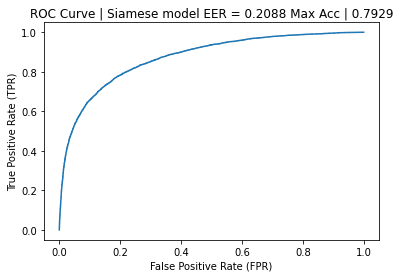

In [32]:
test_dist, max_accuracy, crossover_thresh, crossover_error = evaluate_feat(siamese_base_network, "Siamese model")

(19980, 256) (19980, 256)
cross over error 0.24344344344344349
max accuracy 0.7581081081081081


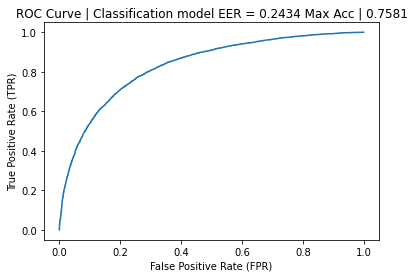

In [33]:
test_dist, max_accuracy, crossover_thresh, crossover_error = evaluate_feat(classsification_base_network , "Classification model")

(19980, 128) (19980, 128)
cross over error 0.23473473473473472
max accuracy 0.806006006006006


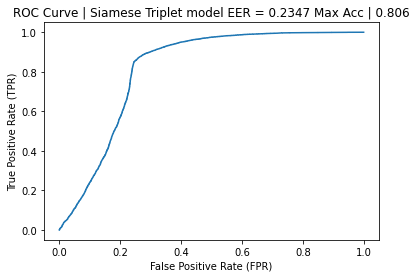

In [34]:
test_dist, max_accuracy, crossover_thresh, crossover_error = evaluate_feat(siamese_triplet_base_network , "Siamese Triplet model") 
